In [1]:
import pandas as pd
pd.set_option('display.max_columns', 5000)

# Load dataset

In [2]:
diamond_df = pd.read_csv('/content/drive/MyDrive/Diamonds/diamond_data.csv')
display(diamond_df.head())

,path_to_img,stock_number,shape,carat,clarity,colour,cut,polish,symmetry,fluorescence,lab,length,width,depth
0,web_scraped/cushion/2106452.jpg,2106452,cushion,0.55,SI2,N,VG,EX,VG,N,GIA,4.56,4.44,3.09
1,web_scraped/cushion/2042329.jpg,2042329,cushion,0.52,SI2,Y-Z,EX,EX,VG,F,GIA,4.40,4.31,2.99
2,web_scraped/cushion/2055268.jpg,2055268,cushion,0.50,SI1,L,VG,EX,VG,N,GIA,4.87,4.19,2.89
3,web_scraped/cushion/2128779.jpg,2128779,cushion,0.50,VS2,M,EX,EX,VG,F,GIA,4.73,4.28,2.84
4,web_scraped/cushion/2103991.jpg,2103991,cushion,0.51,SI1,M,EX,EX,VG,N,GIA,4.47,4.44,3.05


In [3]:
display(diamond_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48765 entries, 0 to 48764
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path_to_img   48765 non-null  object 
 1   stock_number  48765 non-null  object 
 2   shape         48765 non-null  object 
 3   carat         48765 non-null  float64
 4   clarity       48727 non-null  object 
 5   colour        48765 non-null  object 
 6   cut           47750 non-null  object 
 7   polish        48763 non-null  object 
 8   symmetry      48763 non-null  object 
 9   fluorescence  48765 non-null  object 
 10  lab           48765 non-null  object 
 11  length        48765 non-null  float64
 12  width         48765 non-null  float64
 13  depth         48765 non-null  float64
dtypes: float64(4), object(10)
memory usage: 5.2+ MB


None

# Data cleaning

In [38]:
import imghdr
from pathlib import Path

def validate_jpeg_file(x):
    fullpath = Path('/content/drive/MyDrive/Diamonds') / x
    try:
      img_type = imghdr.what(fullpath)
      ret = (img_type in ['jpeg'])
      if not ret:
          print(f'{fullpath} is not a jpeg. It is {img_type}')
    except:
      return False
    return ret

def drop_broken_rows(df):
    valid = df['path_to_img'].map(validate_jpeg_file)
    return df.loc[valid]

In [39]:
diamond_df = drop_broken_rows(diamond_df)
diamond_df = diamond_df.loc[-diamond_df['stock_number'].isin(['220376-42', '220188-630'])]

In [40]:
print(diamond_df.shape)

(814, 14)


# Data exploration

In [43]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def display_diamond(stock_number, df = diamond_df):
    x = df.loc[df['stock_number'] == stock_number].iloc[0]
    path = Path('/content/drive/MyDrive/Diamonds') / x['path_to_img']
    image = Image.open(path)
    plt.imshow(image);
    display(x)
    print('Image size:', image.size)
    print('Image mode:', image.mode)
    return x

In [44]:
import seaborn as sns

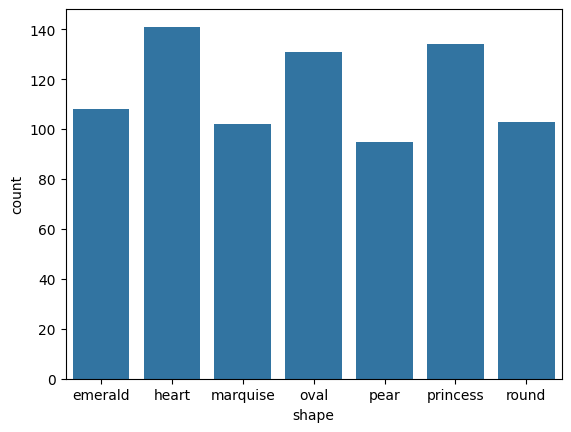

In [45]:
sns.countplot(x = diamond_df['shape']);

# Prepare dataset

Split dataset into train, validation, and test sets.

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_strat_shape(df, test_size = 0.2, random_state = 0):
    splitter = StratifiedShuffleSplit(test_size = test_size, random_state = random_state)
    train_idx, test_idx = next(splitter.split(df, df['shape']))
    return df.iloc[train_idx], df.iloc[test_idx]

In [47]:
df_train_0, df_test = split_strat_shape(diamond_df)
df_train, df_valid = split_strat_shape(df_train_0)
print(df_train.shape, df_valid.shape, df_test.shape)

(520, 14) (131, 14) (163, 14)


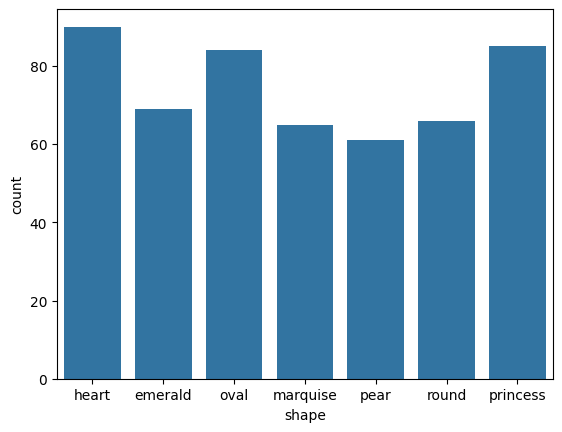

In [48]:
sns.countplot(x = df_train['shape']);

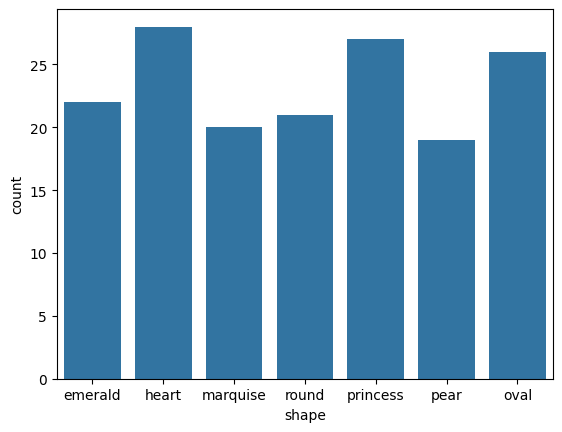

In [49]:
sns.countplot(x = df_test['shape']);

Get the full path of an image and encode shape into integers

In [50]:
shape_classes = list(diamond_df['shape'].unique())
num_shape_classes = len(shape_classes)
print(shape_classes)

['emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']


In [51]:
def make_shape_df(df):
    X_path = df['path_to_img'].map(lambda x: str(Path('/content/drive/MyDrive/Diamonds') / x))
    Y_shape = df['shape'].map(shape_classes.index)
    return X_path, Y_shape

In [52]:
X_path_train, Y_shape_train = make_shape_df(df_train)
display(X_path_train.head())

11870    /content/drive/MyDrive/Diamonds/web_scraped/he...
6693     /content/drive/MyDrive/Diamonds/web_scraped/em...
17284    /content/drive/MyDrive/Diamonds/web_scraped/ov...
12797    /content/drive/MyDrive/Diamonds/web_scraped/ma...
16215    /content/drive/MyDrive/Diamonds/web_scraped/ov...
Name: path_to_img, dtype: object

In [53]:
display(Y_shape_train)

11870    1
6693     0
17284    3
12797    2
16215    3
        ..
7020     0
11985    1
23122    4
36668    6
12774    2
Name: shape, Length: 520, dtype: int64

Convert data into Tensorflow datasets

In [54]:
import tensorflow as tf

In [55]:
image_size = (256, 256)
num_channels = 3

In [56]:
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels = num_channels)
    img = tf.image.resize(img, image_size)
    return img

In [57]:
def make_shape_ds(df):
    X_path_df, Y_shape_df = make_shape_df(df)
    X_shape_ds = (
        tf.data.Dataset.from_tensor_slices(X_path_df)
        .map(read_image, num_parallel_calls = tf.data.AUTOTUNE)
    )
    Y_shape_ds = tf.data.Dataset.from_tensor_slices(Y_shape_df)
    return X_shape_ds, Y_shape_ds

In [58]:
X_shape_train, Y_shape_train = make_shape_ds(df_train)
print(X_shape_train, Y_shape_train)

<_ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)> <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


Shuffle batch, and prefetch for training

In [59]:
batch_size = 32

In [60]:
def prepare_ds(X_ds, Y_ds, seed = 0):
    return (
        tf.data.Dataset.zip(X_ds, Y_ds)
        .shuffle(1000, seed = seed)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

In [61]:
ds_shape_train = prepare_ds(*make_shape_ds(df_train))
ds_shape_valid = prepare_ds(*make_shape_ds(df_valid))

# Build a model

Build a convolutional neural network.

In [62]:
from tensorflow import keras

keras.utils.set_random_seed(0)

In [63]:
model_shape = keras.Sequential(
    layers = [
        keras.layers.Input(shape = (*image_size, num_channels)),
        keras.layers.Rescaling(2. / 255., offset = -1.),

        keras.layers.Conv2D(
            64, 7,
            padding = 'same',
            activation = 'relu',
        ),
        keras.layers.MaxPooling2D(),

        *[
            l
            for s in [
                [
                    *[
                        keras.layers.Conv2D(
                            128 * (2 ** i), 3,
                            padding = 'same',
                            activation = 'relu',
                        )
                        for _ in range(2)
                    ],
                    keras.layers.MaxPooling2D(),
                ]
                for i in range(2)
            ]
            for l in s
        ],

        keras.layers.GlobalAveragePooling2D(),

        *[
            l
            for s in [
                [
                    keras.layers.Dense(256),
                    keras.layers.BatchNormalization(),
                    keras.layers.Activation('relu'),
                    keras.layers.Dropout(0.5),
                ]
                for _ in range(2)
            ]
            for l in s
        ],

        keras.layers.Dense(num_shape_classes, activation = 'softmax'),
    ]
)
model_shape.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                 

# Train the model

In [77]:
model_shape.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy'],
)

Specify class weights.


In [65]:
shape_counts = diamond_df['shape'].value_counts()
shape_class_weights = {
    i: (1. / shape_counts[c]) * (diamond_df.shape[0] / 2.)
    for i, c in enumerate(shape_classes)
}
print(shape_class_weights)

{0: 3.768518518518518, 1: 2.8865248226950353, 2: 3.9901960784313726, 3: 3.1068702290076335, 4: 4.284210526315789, 5: 3.0373134328358207, 6: 3.9514563106796112}


In [66]:
history = model_shape.fit(
    ds_shape_train,
    validation_data=ds_shape_valid,
    epochs=10,  # Reduce the number of epochs
    callbacks=[
        keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True),  # Increase patience
    ],
    class_weight=shape_class_weights,
)

# Save the model manually after training
model_shape.save('cnn_1.tf')

Epoch 1/10
17/17 [==============================] - 684s 40s/step - loss: 6.7394 - sparse_categorical_accuracy: 0.2865 - val_loss: 2.8528 - val_sparse_categorical_accuracy: 0.1221
Epoch 2/10
17/17 [==============================] - 677s 40s/step - loss: 6.1131 - sparse_categorical_accuracy: 0.3404 - val_loss: 5.1874 - val_sparse_categorical_accuracy: 0.2061


# Evaluate the model

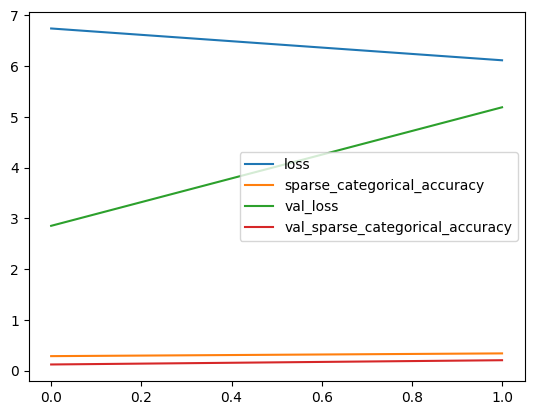

In [67]:
pd.DataFrame(history.history).plot();

In [68]:
X_shape_test, Y_shape_test = make_shape_ds(df_test)
ds_shape_test = (
    tf.data.Dataset.zip(X_shape_test, Y_shape_test)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [69]:
print(model_shape.evaluate(ds_shape_test))

6/6 [==============================] - 57s 9s/step - loss: 2.8553 - sparse_categorical_accuracy: 0.1288
[2.85530948638916, 0.12883435189723969]


In [70]:
Y_shape_proba = model_shape.predict(ds_shape_test)
Y_shape_pred = Y_shape_proba.argmax(axis = 1)
print(Y_shape_pred)

6/6 [==============================] - 59s 9s/step
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [72]:
import numpy as np

Y_shape_true = np.asarray(list(Y_shape_test))
print(Y_shape_true)

[0 1 2 6 5 1 2 5 4 2 5 4 3 1 3 1 0 2 5 5 2 0 3 6 0 4 5 4 3 5 2 1 5 1 0 1 6
 0 5 2 2 4 5 0 1 1 1 4 5 5 6 3 2 2 6 1 6 2 5 0 3 2 1 3 4 4 2 4 3 2 6 0 5 6
 5 1 1 3 1 1 5 1 0 3 0 5 1 0 6 1 6 5 0 3 1 1 2 1 6 4 0 6 2 3 1 6 3 4 4 5 0
 5 6 1 1 2 3 5 0 6 0 4 1 3 4 5 0 3 3 4 5 3 4 5 1 2 0 6 4 3 3 6 0 5 6 6 1 4
 6 3 2 0 4 6 3 3 3 3 2 0 3 5 5]


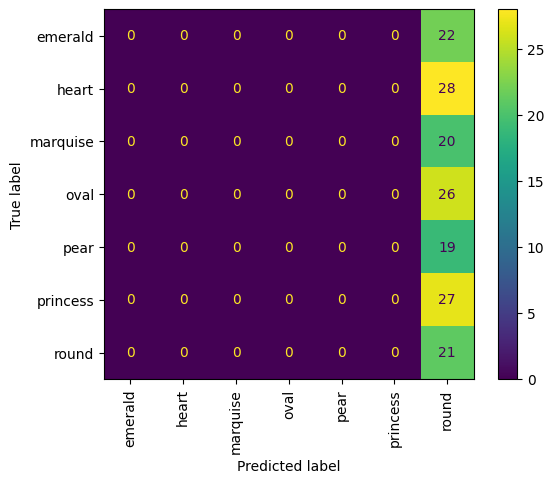

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    Y_shape_true, Y_shape_pred,
    display_labels = shape_classes,
    xticks_rotation = 'vertical',
);